# Interpolated Waveforms

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pulser
from pulser import Pulse, Sequence, Register
from pulser.devices import AnalogDevice
from pulser.waveforms import InterpolatedWaveform

In some particular applications (the most notorious being its use in optimal control at the pulse level) it is useful to define a waveform through the interpolation of a set of data points. For these cases, Pulser provides the `InterpolatedWaveform` class.

In its most stripped back form, the `InterpolatedWavefrom` requires two things: a `duration` and a list of `values`. The placement of these values along the times axis defaults to spacing the values evenly along the whole duration of the waveform. 

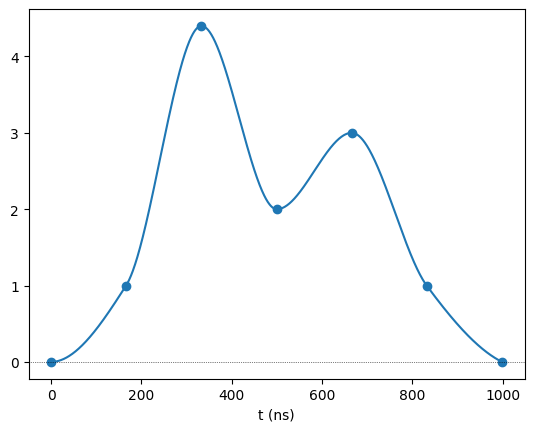

In [2]:
# A standard interpolation (using PchipInterpolator)
duration = 1000
values = [0, 1, 4.4, 2, 3, 1, 0]
int_wf = InterpolatedWaveform(duration, values)
int_wf.draw()

If we want to specify the time coordinate of each data point, we can do so through the `times` option. These should come in a list of values betwen `0` and `1`, which are interperted as fractions of the total duration. As an example, below we specify that the `values` are all bunched in the first half of the waveform, except for the last one, which is left at the end.

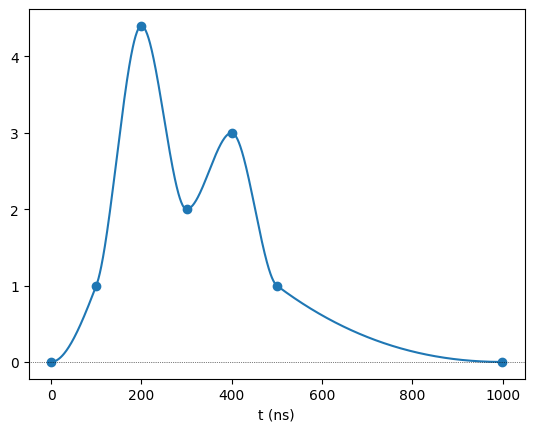

In [3]:
ts = np.r_[np.linspace(0.0, 0.5, num=len(values) - 1), 1]
int_wf_t = InterpolatedWaveform(duration, values, times=ts)
int_wf_t.draw()

The other crucial component is the `interpolator`. Currently, the class supports two interpolator classes from the `scipy.interpolate` module: `PchipInterpolator` (chosen by default) and `interp1d`. Below, we change the interpolator to `interp1d`, which does a linear interpolation by default:

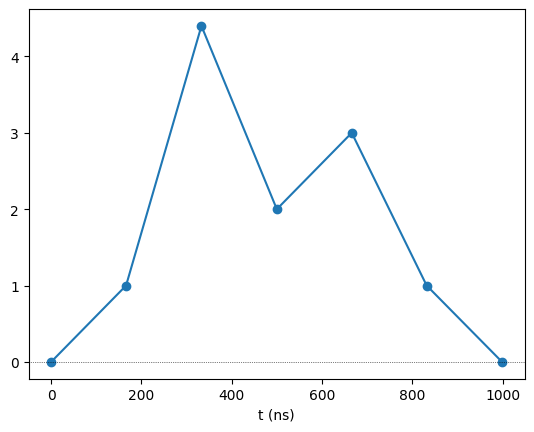

In [4]:
int_wf2 = InterpolatedWaveform(duration, values, interpolator="interp1d")
int_wf2.draw()

One can also change the optional parameters of the chosen interpolator by giving them to `InterpolatedWaveform`. For example, the interpolation with `interp1d` can be cubic instead of linear by changing the `kind` parameter.

Naturally, the choice of interpolator will dictate which extra parameters can be optionally provided. As such, one must refer to the chosen interpolator's documentation for the specific details.

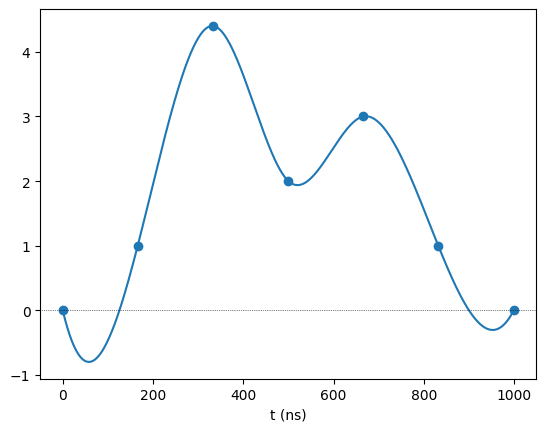

In [5]:
int_wf3 = InterpolatedWaveform(
    duration, values, interpolator="interp1d", kind="cubic"
)
int_wf3.draw()

Finally, an `InterpolatedWaveform` can be streched or contracted in both magnitude and duration: 

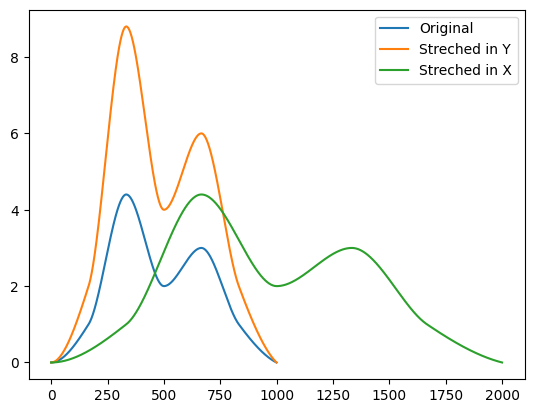

In [6]:
# Streching an interpolated waveform
int_wf_stretch_y = int_wf * 2
int_wf_stretch_x = int_wf.change_duration(duration * 2)

fig, ax = plt.subplots()
ax.plot(int_wf.samples, label="Original")
ax.plot(int_wf_stretch_y.samples, label="Streched in Y")
ax.plot(int_wf_stretch_x.samples, label="Streched in X")
ax.legend()
plt.show()

### Use in a parameterized sequence

The `InterpolatedWaveform` is used like any other waveform. In the contexts where it usually comes up, it might be helpful to incorporate it in a parametrized sequence. Below, we'll show how to make a parametrized sequence where the data points for the amplitude and detuning waveforms are variables.

In [7]:
reg = Register.square(1, prefix="q")
param_seq = Sequence(reg, AnalogDevice)
param_seq.declare_channel("rydberg_global", "rydberg_global", initial_target=0)
amp_vals = param_seq.declare_variable("amp_vals", size=5, dtype=float)
det_vals = param_seq.declare_variable("det_vals", size=4, dtype=float)

amp_wf = InterpolatedWaveform(1000, amp_vals)
det_wf = InterpolatedWaveform(
    1000, det_vals, interpolator="interp1d", kind="cubic"
)
pls = Pulse(amp_wf, det_wf, 0)

param_seq.add(pls, "rydberg_global")

From here, we can build some random sequence by specifying the values of `amp_vals` and `det_vals`. For example:

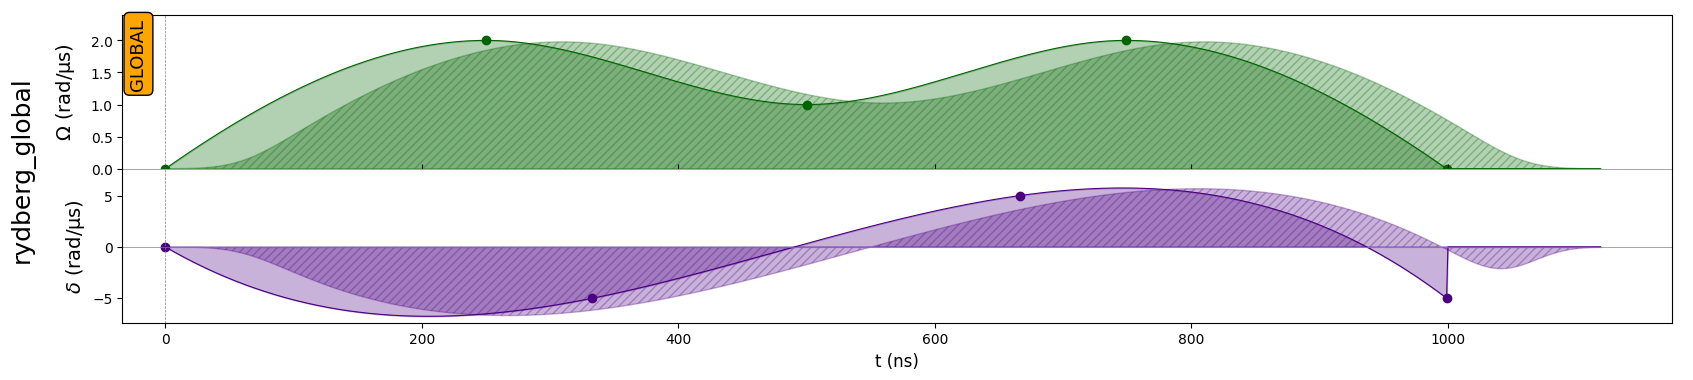

In [8]:
seq1 = param_seq.build(amp_vals=[0, 2, 1, 2, 0], det_vals=[0, -5, 5, -5])
seq1.draw()

Notice how the interpolation points are automatically drawn on top of the waveforms. You can disable this option through the `draw_interp_pts` parameter:

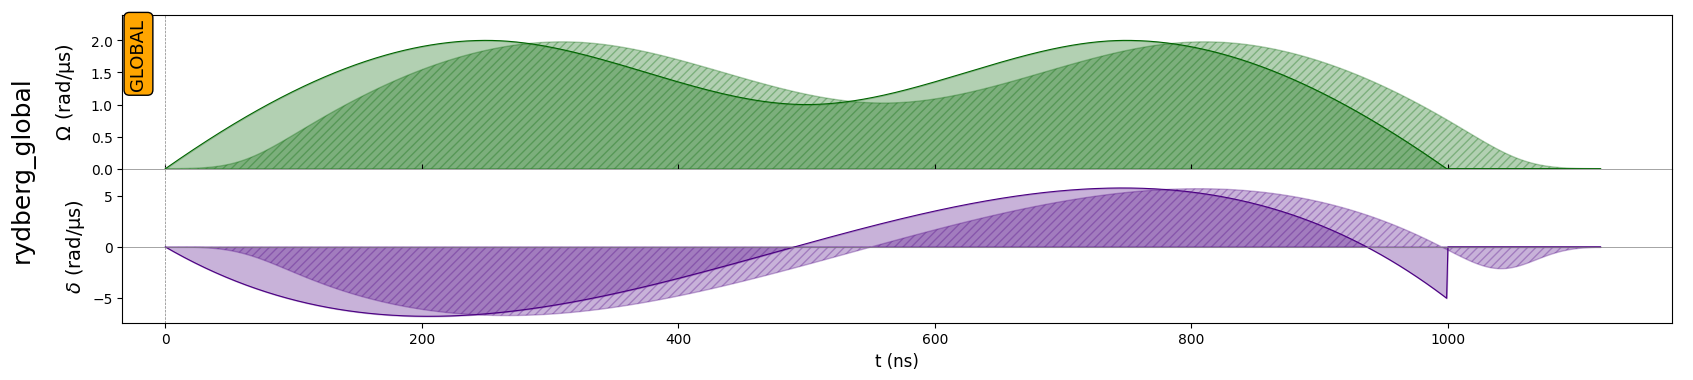

In [9]:
seq1.draw(draw_interp_pts=False)